In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
n = 2500
x = np.random.uniform(-5,5,size=(n,1))
#y = x * 0+ .1 * np.sin(6*x) + np.random.uniform(-.1,.1,size=(n,1))
y = 10 + x ** 2 - 10 * np.cos(2*np.pi*x) + np.random.normal(0,5,size=(n,1))
#y = x 

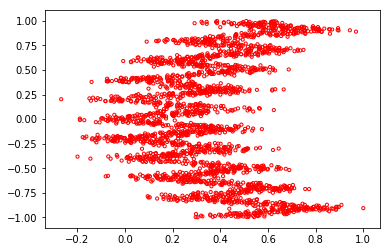

In [3]:
plt.scatter(y/np.max(y),x/np.max(x),s=10, facecolors='none', edgecolors='r')

In [ ]:
#Create the MDN network
tf.reset_default_graph()

tf.set_random_seed(1)

def create_mdn(inputs,k):
    regularizer = None
    act = tf.nn.relu
    x = tf.layers.dense(inputs, 32, activation=act, kernel_regularizer=regularizer)
    
    out = tf.layers.dense(x, 3 * k, activation=None, kernel_regularizer=regularizer)
    
    out_weights = tf.nn.softmax(out[:,:k])
    out_means = out[:,k:2*k]
    out_sigmas = tf.exp(out[:,2*k:]) + 1e-8
    
    return out_weights, out_means, out_sigmas

#Returns array of 1/(sqrt(2*pi*sigma_i^2)) *\
#                 e^( - ((y-x_i)^2) / (2*sigma_i^2) )
# for scalars mu and sigma and input vector y
def gaussian_pdf(y,mu,sigma):
    val = -tf.square(tf.divide(y-mu,sigma))/2
    return tf.divide(tf.exp(val),sigma) * (1/np.sqrt(2*np.pi))



def log_loss(y_vec,mu_vec,sigma_vec,alpha_vec):
    mixture_likelihoods = gaussian_pdf(y_vec,mu_vec,sigma_vec)
    E_q = -tf.log(tf.reduce_mean(tf.multiply(mixture_likelihoods,alpha_vec),1,
                               keep_dims=True)+1e-8)
    return mixture_likelihoods, tf.reduce_mean(E_q)


bs = 100
X = tf.placeholder(tf.float32, (None, 1))
Y = tf.placeholder(tf.float32, (None, 1))

alpha_vec, mu_vec, sigma_vec = create_mdn(X,25)
ml, loss = log_loss(Y,mu_vec,sigma_vec,alpha_vec)
grads = tf.gradients(loss, tf.all_variables())
grads_vars = [(i,j) for (i,j) in zip(grads,tf.all_variables())]

sub = tf.subtract(Y, mu_vec)
optimizer = tf.train.RMSPropOptimizer(1e-3)
#train_op = optimizer.minimize(loss)
train_op = optimizer.apply_gradients(grads_vars)

In [5]:
losses = []

sess = tf.Session()
sess.run(tf.global_variables_initializer())
mls = []
alphs = []
sigmas = []
mus = []
ggs = []

x_train = x/np.max(x)
y_train = y/np.max(y)

#x_train = x
#y_train = y

for ep in tqdm(range(1000)):

    shuffled_inds = np.random.permutation(np.arange(x.shape[0]))

    x_train = x_train[shuffled_inds]
    y_train = y_train[shuffled_inds]
    
    for it in range(int(x.shape[0]/bs)):
        x_batch = y_train[it*bs:(it+1)*bs]
        y_batch = x_train[it*bs:(it+1)*bs]
        
        l,a,g,s,m,mm,_ = sess.run([loss,alpha_vec,grads_vars,sigma_vec, ml, mu_vec, train_op],
                           feed_dict={X:x_batch,Y:y_batch})
        
        if np.isnan(l):
            print("Nan!!")
            break
            
    #mls.append(m)
    #alphs.append(a)
    #sigmas.append(s)
    #mus.append(mm)
    #ggs.append(g)
        
    if np.isnan(l):
        print("Nan!!")
        break
        
    if ep % 100 == 0:
        print("Loss: %f" % l)
            
    losses.append(l)

#mls = np.array(mls)[:-1]
#alphs = np.array(alphs)[:-1]
#sigmas = np.array(sigmas)[:-1]
#mus = np.array(mus)[:-1]
#ggs = np.array(ggs)

A Jupyter Widget

Loss: 4.316934
Loss: 3.550682
Loss: 3.343416
Loss: 3.231340
Loss: 3.373766
Loss: 3.209625
Loss: 3.145855
Loss: 3.137960
Loss: 3.145061
Loss: 3.132480



In [6]:
#np.min(mls),np.max(mls)

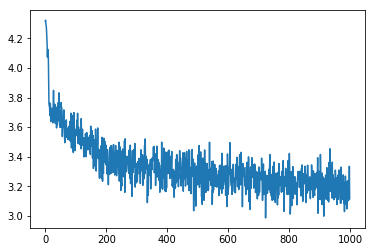

In [7]:
plt.plot(losses)

In [8]:
np.min(losses)

2.9858036

In [9]:
x_test = np.arange(np.min(y_train),np.max(y_train),.0001).reshape(-1,1)
av,mv,sv = sess.run([alpha_vec, mu_vec, sigma_vec], feed_dict={X:x_test})

In [10]:
y_test = np.random.normal(0,1,size=x_test.shape)
for i in range(x_test.shape[0]):
    ind = np.random.choice(np.arange(av.shape[1]),p=av[i])
    y_test[i] = y_test[i]*sv[i,ind] + mv[i,ind]

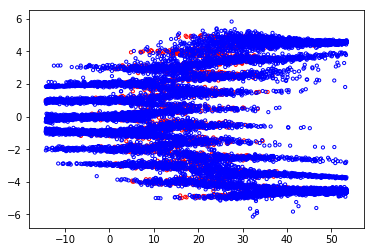

In [11]:
plt.scatter(y,x,s=10, facecolors='none', edgecolors='r')
plt.scatter(x_test*(np.max(y)/np.max(x_train)) ,y_test*(np.max(x)/np.max(y_train)),
            s=10, facecolors='none', edgecolors='b')